In [133]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
llm = ChatGroq(
     model="qwen/qwen3-32b", # or 'llama3-70b-8192', 'mixtral-8x7b-32768'
)

In [134]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END

In [135]:

import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [136]:
search_tool.invoke("who is a current pm of uk?")

[{'title': 'Prime Minister - GOV.UK',
  'url': 'https://www.gov.uk/government/ministers/prime-minister',
  'content': 'The Prime Minister is the leader of His Majesty’s Government and is ultimately responsible for the policy and decisions of the government.\n\nAs leader of the UK government the Prime Minister also:\n\n## Current role holder\n\n### The Rt Hon Sir Keir Starmer KCB KC MP\n\nSir Keir Starmer became Prime Minister on 5 July 2024.\n\n## Education [...] Keir attended Reigate Grammar School, before studying Law at the University of Leeds. He went on to do postgraduate studies at the University of Oxford, receiving a Bachelor of Civil Law (BCL) degree.\n\n## Political Career\n\nKeir was elected a Member of Parliament for Holborn and St Pancras in May 2015. He was elected leader of the Labour Party in April 2020.\n\n## Career before politics [...] Find out more about previous holders of this role in our past Prime Ministers section.\n\n## Announcements\n\n## Subscriptions\n\n## 

In [137]:
from langchain_experimental.utilities import PythonREPL
repl=PythonREPL()

In [138]:
from typing import Annotated

In [139]:
@tool 
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""

    try:
        result=repl.run(code)
    except BaseException as e:
        return f"Failed to execut . Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


<>:12: SyntaxWarning: invalid escape sequence '\`'
<>:12: SyntaxWarning: invalid escape sequence '\`'
<>:12: SyntaxWarning: invalid escape sequence '\`'
<>:12: SyntaxWarning: invalid escape sequence '\`'
C:\Users\rohit\AppData\Local\Temp\ipykernel_12700\633848476.py:12: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\rohit\AppData\Local\Temp\ipykernel_12700\633848476.py:12: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [140]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\nyou should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x0000023DEAA83F60>)

In [141]:
def make_system_prompt(instruction: str) -> str:
    return (
        "You are a specialized AI assistant with strict role limitations. "
        "You MUST follow these rules:\n"
        "1. Perform ONLY your assigned role\n"
        "2. Use ONLY the tools provided to you\n"
        "3. Never attempt tasks outside your role\n"
        "4. Clearly hand off to other specialists when needed\n"
        "5. If you see 'FINAL ANSWER' in the conversation, end the task\n"
        f"\nYour specific role: {instruction}"
    )

In [142]:
from langchain_core.messages import BaseMessage, HumanMessage

In [143]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [144]:
from typing import Literal
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, StateGraph, START, END

In [145]:
# Agent 1: Researcher
def research_node(state: MessagesState) -> Command[Literal["chart_generator", "__end__"]]:
    research_agent = create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
            "You are ONLY a research specialist. Your tasks:\n"
            "1. Search for requested data using your tools\n"
            "2. Format the data clearly\n"
            "3. Pass to chart generator when data is ready\n"
            "NEVER attempt to generate charts yourself"
        ),
    )
    
    result = research_agent.invoke(state)
    
    # Ensure we're only passing clean research data
    last_message = result["messages"][-1]
    if "```python" in last_message.content:
        last_message.content = "Please remove any code and only provide research data"
    
    goto = get_next_node(last_message, "chart_generator")
    return Command(update={"messages": result["messages"]}, goto=goto)

In [146]:
# Agent 2: Chart Generator
def chart_node(state: MessagesState) -> Command[Literal["researcher", "__end__"]]:
    chart_agent = create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
            "You are ONLY a chart generation specialist. Your tasks:\n"
            "1. Look for messages containing 'GDP_DATA:'\n"
            "2. Generate matplotlib code to create a line chart\n"
            "3. Return the chart output\n"
            "4. Include 'FINAL ANSWER' when done\n"
            "NEVER attempt to research data yourself"
        )
    )
    
    result = chart_agent.invoke(state)
    last_message = result["messages"][-1]
    
    goto = get_next_node(last_message, "researcher")
    
    if isinstance(last_message, HumanMessage):
        result["messages"][-1] = HumanMessage(
            content=last_message.content, 
            name="chart_generator"
        )
    
    return Command(
        update={"messages": result["messages"]},
        goto=goto
    )

In [147]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

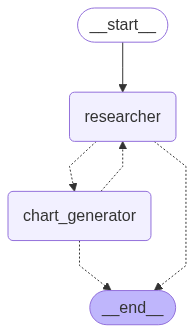

In [148]:
workflow.compile()

In [149]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

Task researcher with path ('__pregel_pull', 'researcher') wrote to unknown channel branch:to:__end__, ignoring it.


{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='cbe5b961-c8f2-4a64-bbe7-8ccb4da0077a'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the UK\'s GDP over the past three years and then a line chart. Let me break this down.\n\nFirst, I need to get the GDP data. I\'m a research specialist, so I should use the provided tool, which is tavily_search_results_json. The function requires a query parameter. I\'ll need to search for UK GDP data for the last three years. The query should be specific enough to get accurate results. Maybe something like "UK GDP past 3 years official statistics" to ensure it\'s from reliable sources.\n\nOnce I get the search results, I need to extract the data. The results might be in JSON format, so I\'ll look for the relevant GDP figures. I need to make sure the data is accurate an

Python REPL can execute arbitrary code. Use with caution.


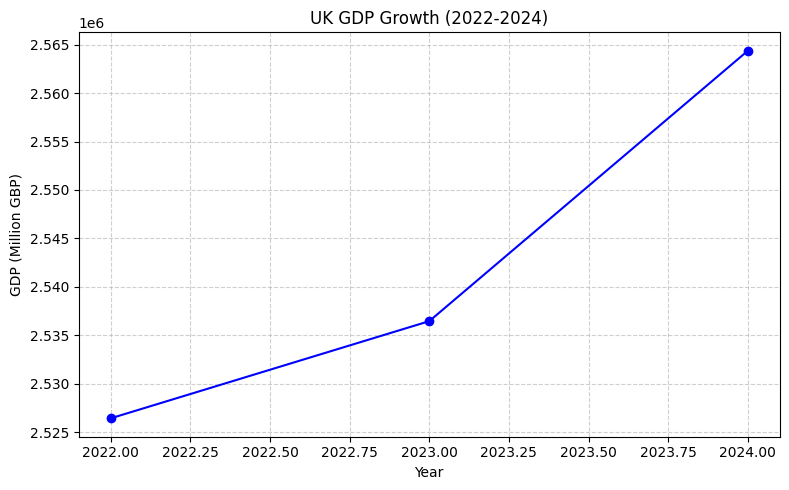

Task chart_generator with path ('__pregel_pull', 'chart_generator') wrote to unknown channel branch:to:__end__, ignoring it.


{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='d04cff4b-d496-47f8-ba18-67d91dfb7f2f'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user wants the UK\'s GDP over the past three years and then a line chart. Let me start by figuring out which function to use. The available tool is tavily_search_results_json, which takes a query. I need to search for the UK\'s GDP data for the last three years.\n\nFirst, I\'ll construct a query. Something like "UK GDP past 3 years" should work. I\'ll use the tavily_search_results_json function with that query. Once I get the search results, I can extract the data. The results might have the GDP values for each year. I need to make sure the data is accurate and from a reliable source. After gathering the data, I\'ll format it clearly, maybe in a table with years and corresponding GDP valu

In [150]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})